# Target leakage example: classifying text data (tweets)

In this lab, we will load a new dataset from disk, clean it up and prepare it for training. The data here is of text type, as this is a dataset of 3000 tweets. So, we have to deal with short text inputs.

Each tweet has been written by one of two well-known individuals from the world of US politics. Our task is simply to decide who wrote it. Donald or Hillary?

<img src="figures/trump-clinton-split.jpg">

The first question here is: how do we deal with string inputs? We can't multiply a word by a weight, so we need to translate the text input in numbers before we proceed and feed it to our first layer. In this case, there are usually two options. The first is called "one-hot" encoding, where each word in a dictionary is translated to a vectors of ones and zeros. If there are 10 words in our dictionary (for example, the words are "zero", "one", "two" ... "nine"), each vector will contain ten elements, with nine elements set to zero and one set to one:

* "zero" -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* "one"  -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
* "two"  -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
* ...
* "nine" -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

This is usually ok when dealing with text (or, more generically, "categorical") variables taken from a relatively small dictionary. In the case of tweets, we might be dealing with very a dictionary containing tens of thousands of different terms, so we would have huge inputs of sparse vectors of zeros and ones. This is not ideal.

The second option is to use word embeddings, which translate each word to a vector of floating points with some nice properties, as we can see in the following image:

<img src="figures/Word-Vectors.png">

Check out [this cool page](https://anvaka.github.io/pm/#/galaxy/word2vec-wiki?cx=-17&cy=-237&cz=-613&lx=-0.0575&ly=-0.9661&lz=-0.2401&lw=-0.0756&ml=300&s=1.75&l=1&v=d50_clean) visualizing embeddings calculated on the whole English dictionary for more examples.

Embeddings are done with a special NN layer that in Keras is called simply "Embedding" (https://keras.io/layers/embeddings/). The Embedding layer is provided with a number of text inputs (in our case, tweets) and learns to map similar words into n-dimensional vectors that are close together in the corresponding n-dimensional space.

In the following piece of code, we will start by loading the dataset with [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html) and preparing it for training.

Notice how before we can use the Embedding layer, we want to map each word to an integer. This is because the input to an Embedding layer is actually a set of integers, where each integer represents a word. The important thing here, is that a given word has to be mapped always to the same integer throughout the whole dataset, so that the Embedding layer can recognise it from different tweets.

In this case, for example, the word "the" will always be mapped to the number 1, the word "question" to the number 2, etc.

* "The question is what to do"      -> [1, 2, 32, 55, 87]
* "I don't understand the question" -> [12, 4, 123, 1, 2]

Let's start by defining a helper function to plot training and validation curves:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss_acc(history, save_path=None, dpi=300):
    # Create a square figure
    fig, ax = plt.subplots(figsize=(5, 5))  # Square figure dimensions

    try:
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    except KeyError:  # Handle older Keras versions
        ax.plot(history.history['acc'], label='Train Accuracy')
        ax.plot(history.history['val_acc'], label='Validation Accuracy')
    
    ax.set_title('Model Accuracy and Loss')
    ax.set_ylabel('Value')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper left')
    
    # Keep the figure square, but let axes autoscale
    ax.set_box_aspect(1)  # Forces the axes box to be square, but doesn't squash the data
    
    # Save plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Plot saved to {save_path} with {dpi} DPI")
    
    plt.show()


Download the dataset (uncomment and run)

In [ ]:
#!mkdir data/
#!wget -P data https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/blob/961c3a45c3fd3603e6c31bac1c09f468c8e196bc/session_goodPracticesDatasetDesign/lab_targetLeakage/data/tweets.csv

Now let's load the dataset, which in this case is saved as CSV file, and let's print one tweet:

In [2]:
import pandas as pd

tweet_dataset = pd.read_csv("data/tweets.csv")

In [3]:
print(tweet_dataset.shape)

(6444, 28)


In [17]:
# Count the number of tweets per handle
handle_counts = tweet_dataset['handle'].value_counts()

# Print the counts
print("Tweet counts by handle:")
print(handle_counts)

Tweet counts by handle:
handle
realDonaldTrump    3093
HillaryClinton     2629
Name: count, dtype: int64


In [4]:
tweet_dataset.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [16]:
tweet_dataset["text"][0]

nan

Then we apply a few basic operations to handle it more easily, for example:

* We add a space after every non-alphanumeric character so that we have, for example "-Hello" -> "- Hello"
* We make all words lower case, so that "Hello" == "hello"
* Lastly, we split each tweet by using space as delimiter, so that we have a list of words for each tweet

Then we assign a unique integer to each unique word in the dataset, so that we can translate each tweet to a list of numbers. But equal numbers will always correspond to equal words across all tweets! Notice how we reserve the integer "0" for "padding". This means that since the longest tweet has 58 words (so a list of 58 integers), we will add a series of "0"s to shorter tweets until they are also represented by a list of 58 integers.

Lastly, we assign to our labels (in this case the author of the tweets) one class between 0 and 1.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#Get rid of all retweets
tweet_dataset = tweet_dataset[tweet_dataset["is_retweet"] == False]

#Remove URLs
#tweet_dataset["text"] = tweet_dataset["text"].str.replace('http\S+|www.\S+', '', case=False)

#Now let's make sure that non-alphanumeric characters are taken as single words
tweet_dataset["text"] = tweet_dataset["text"].str.replace('\s*([^a-zA-Z0-9 ])\s*', ' \\1 ', case=False)

#remove hashtags
tweet_dataset["text"] = tweet_dataset["text"].str.replace('#[a-zA-Z0-9]*', '', case=False)

#remove @ mentions
tweet_dataset["text"] = tweet_dataset["text"].str.replace('@[a-zA-Z0-9]*', '', case=False)

#make all words lower case?
tweet_dataset["text"] = tweet_dataset["text"].str.lower()

#split the tweets in list of words
tweet_dataset["text"] = tweet_dataset["text"].str.strip()
tweet_dataset["text"] = tweet_dataset["text"].str.split(" ")

#since the neural networks don't really like string inputs,
#we have to convert each word to a unique integer.
integer_dict = {}
integer_dict["padding"] = 0

word_dict = {}
word_dict[0] = "padding"

#assign a unique integer to each unique word
count = 1
for index, row in tweet_dataset.iterrows():
    for element in row["text"]:
        if element not in integer_dict.keys():

            integer_dict[element] = count
            word_dict[count] = element
            count += 1
    
tweet_dataset["numbers"] = tweet_dataset["text"].apply(lambda x:[integer_dict[y] for y in x])

#Let's also assign integer labels 
tweet_dataset.loc[tweet_dataset["handle"] == "realDonaldTrump","label"] = 1
tweet_dataset.loc[tweet_dataset["handle"] == "HillaryClinton","label"] = 0

#The longest tweet has 58 words, this will add padding to shorter tweets
train_x = pd.DataFrame(tweet_dataset["numbers"].values.tolist()).values
train_x[np.where(np.isnan(train_x[:]))] = 0

train_y = np.array(tweet_dataset["label"])


AttributeError: Can only use .str accessor with string values!

Check the effect that this has had on the first tweet:

In [11]:
tweet_dataset["text"][0]
#train_x[0]

nan

Now, we will see how we can use Embeddings to transform our dictionary of words into a dictionary of float vectors.

First, let's use Embeddings, followed by Dense layers:

In [12]:
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout

model = Sequential()

model.add(Embedding(input_dim=count, output_dim=16, input_length=train_x.shape[1], name='embeddings'))
model.add(Flatten()) #Dense layers only accept 1D inputs, so we need to flatten the output from Embedding, which is 2D
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',                    #adaptive learning rate method
              loss='sparse_categorical_crossentropy', #loss function for classification problems with integer labels
              metrics=['accuracy'])                   #the metric doesn't influence the training

hist = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_split=0.2)


2024-11-24 22:59:25.516254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 31, 16)            302576    
                                                                 
 flatten (Flatten)           (None, 496)               0         
                                                                 
 dropout (Dropout)           (None, 496)               0         
                                                                 
 dense (Dense)               (None, 10)                4970      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 307,568
Trainable params: 307,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
144/144 [==============================

In [13]:
from tensorflow.keras.utils import plot_model

# Save the model plot to a file
plot_model(
    model,  # Your Keras model
    to_file='model_architecture.png',  # Path to save the image
    show_shapes=True,  # Display layer output shapes
    show_layer_names=True,  # Display layer names
    dpi=300  # High resolution
)


AttributeError: module 'pydot' has no attribute 'InvocationException'

Plot saved to training_plot.png with 300 DPI


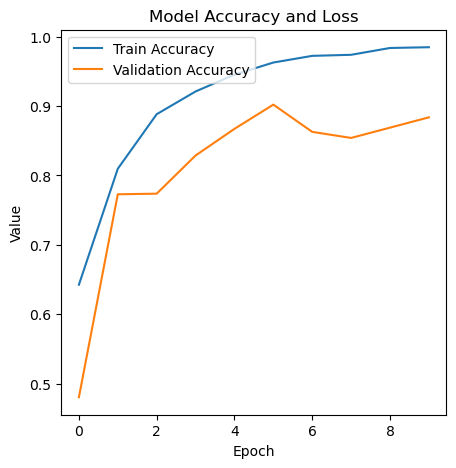

In [14]:
plot_loss_acc(hist, save_path='training_plot.png', dpi=300)


When a model has been trained, you can call the method `predict()` to get the predictions for all future samples. 
That is how you actually use your model when the job is done!

Can you think of a good dataset that you could use to test your model?

In [15]:
tweet = "at least 17 States have joined texas in the extraordinary case against the greatest Election"
tweet = tweet.lower()
words = tweet.split(" ")

tweet_integer = np.array([integer_dict[element] for element in words])

tweet_padded = np.zeros(58)
tweet_padded[:15] = tweet_integer

tweet_padded = tweet_padded[np.newaxis, :]
print(tweet_padded.shape)
result = model.predict(tweet_padded)

print(result)

(1, 58)


ValueError: in user code:

    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/Caskroom/miniconda/base/envs/nn_python/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 31), found shape=(None, 58)


## Questions

* Which type of network works best?
* What could be a better network layer given the nature of this dataset?
* What is the meaning of the "count" variable used in the Embedding layer?
* Why does the last layer have 2 units? Why is the activation of the 'softmax' type?
* Play around with the hyperparameters, is there a way to improve the models?

Now let's visualize the outputs of the embedding layer. We extract the embedding layer from the trained model and we use it to calculate embeddings for every word in our dictionary. Then, we map the 32-dimensional output vector onto 2 dimensions with the help of principal component analysis (PCA).

32/32 [==============================] - 0s 999us/step
Plot saved as embeddings_plot.png with 300 DPI.


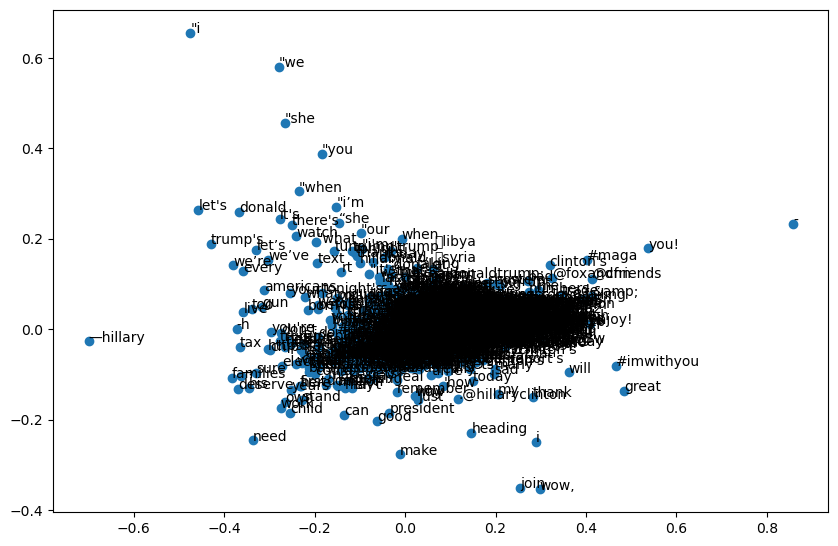

In [45]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import mpld3
mpld3.enable_notebook()

from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np  # Ensure NumPy is imported
plt.rcParams['figure.figsize'] = [10, 10]  # Set square figure size

# Extract the embeddings layer from the previous model and use it as output in a new model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('embeddings').output)

n_words = 1000
inputs = np.zeros((n_words, train_x.shape[1]))
for i in range(n_words):
    for c in range(train_x.shape[1]):
        inputs[i, c] = i

# Get embeddings from the intermediate layer
intermediate_output = intermediate_layer_model.predict(inputs)

# Perform PCA to reduce dimensions to 2D
points = np.squeeze(intermediate_output[:, 0, :])
pca = PCA(n_components=2, svd_solver='full')
points_pca = pca.fit_transform(points)

# Plot the PCA-transformed embeddings
fig, ax = plt.subplots()
ax.scatter(points_pca[:, 0], points_pca[:, 1])

# Annotate points with word labels
for i in range(n_words):
    ax.annotate(word_dict[i], (points_pca[i, 0], points_pca[i, 1]))

# Set the aspect ratio to be equal for a square plot
ax.set_aspect('equal')

# Save the plot to a file
save_path = 'embeddings_plot.png'  # Specify the filename
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save with high resolution
print(f"Plot saved as {save_path} with 300 DPI.")

plt.show()


## Questions: what is wrong (or right) with this dataset?

* Take a few minutes to analyze the word cloud. Can you see what kind of words make the classification easier? If you wanted to make a less biased (and harder to classify) dataset, what would you change? 

* If possible, go back to the dataset generation step and remove words that make the classification task too easy. Then, try and train a new network. Are the results the same as before?

* Why do you think that the "Dense" network (Feed-forward, fully connected) works as well as the LSTM recurrent network on the dataset as it is now?

* Now that we have trained and validated our model, what would you suggest using as test set?

Here are a few examples of how the dataset can be manipulated. Try these lines of code (and come up with some others!) by pasting them in the right place the code block where the dataset is loaded (second code cell):

```python
#Get rid of all retweets
tweet_dataset = tweet_dataset[tweet_dataset["is_retweet"] == False]

#Next, let's remove all URLs, since they should not be of any help (unless we actually checked what they link to)
tweet_dataset["text"] = tweet_dataset["text"].str.replace('http\S+|www.\S+', '', case=False)

#remove hashtags
tweet_dataset["text"] = tweet_dataset["text"].str.replace('#[a-zA-Z0-9]*', '', case=False)

#Remove a word
tweet_dataset["text"] = tweet_dataset["text"].str.replace('crooked', '', case=False)

#Remove non-alphanumeric characters
tweet_dataset["text"] = tweet_dataset["text"].str.replace('\s*([^a-zA-Z0-9 ])\s*', '', case=False)

```